# Presto card usage
Data from my prestocard.ca account

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from fbprophet import Prophet

In [2]:
## Load data
presto = pd.read_csv("presto_trans.csv",
                    converters={'Amount': lambda s: float(s.replace('$', ''))})
presto['Date'] = pd.to_datetime(presto['Date'])
presto.columns = ["Date","TransitAgency","Type","ServiceClass","Discount","Amount","Balance"]

## Only count TTC (essentially exclude trips to airport)
presto = presto.query('TransitAgency == "Toronto Transit Commission"')

### Data exploration

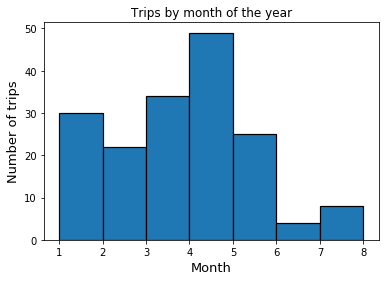

In [3]:
plt.hist(presto['Date'].apply(lambda x: x.month), bins=7, edgecolor='k')
plt.xlabel('Month', fontsize=13)
plt.ylabel('Number of trips',fontsize=13)
plt.title('Trips by month of the year')
plt.show()

I was out of town for 10 days in February. Started biking in May

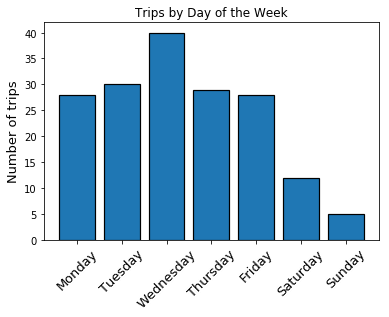

In [4]:
by_weekday = presto.groupby(presto['Date'].dt.weekday_name).count().Date
by_weekday = by_weekday.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
x = np.arange(len(by_weekday))
plt.bar(x, by_weekday, edgecolor='k')
plt.xticks(x, by_weekday.index)
plt.xticks(rotation=45)
plt.xticks(fontsize=13)
plt.ylabel('Number of trips',fontsize=13)
plt.title('Trips by Day of the Week')
plt.show()

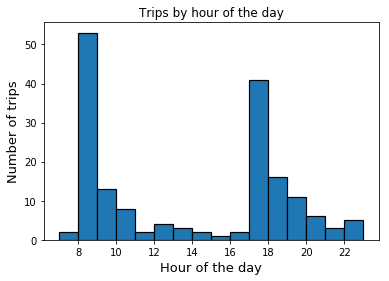

In [5]:
presto['Hour'] = presto['Date'].apply(lambda x: x.hour)

min_hour = presto['Hour'].min()
max_hour = presto['Hour'].max()

plt.hist(presto.Hour, bins= (max_hour-min_hour), edgecolor='k')
plt.xlabel('Hour of the day', fontsize=13)
plt.ylabel('Number of trips',fontsize=13)
plt.title('Trips by hour of the day')
plt.show()

### Card usage vs. time

Text(0.5,0,'Date')

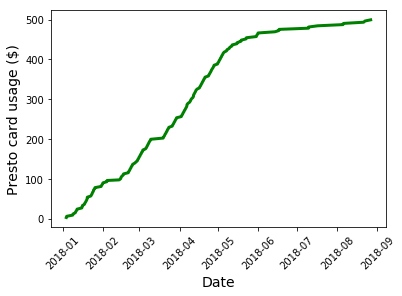

In [6]:
fpp = presto.groupby('Date').sum()[['Amount']]
plt.plot(np.cumsum(fpp), color='g', linewidth=3, label='Actual')
plt.xticks(rotation=45)
plt.ylabel('Presto card usage ($)', fontsize=14)
plt.xlabel('Date', fontsize=14)

## Now fit a simple line
Only up to May 8th, the date when I started biking

In [7]:
## Fit a line to data before 2018-05-08
presto_bf = presto.query('Date < "2018-05-08"')
fpp_bf = presto_bf.groupby('Date').sum()[['Amount']]
regr = LinearRegression()
regr.fit(fpp_bf.index.values.reshape(-1,1), np.cumsum(fpp_bf.Amount).values.reshape(-1,1))
rng = pd.date_range('1/1/2018', periods=80, freq='3D')
pred = regr.predict(rng.values.astype(float).reshape(-1,1))

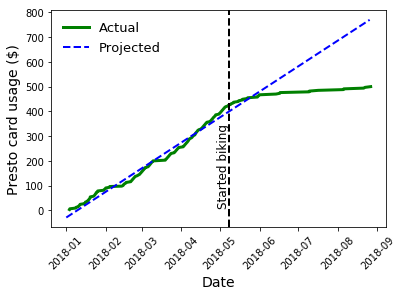

In [8]:
## Plot data
fpp = presto.groupby('Date').sum()[['Amount']]
plt.plot(np.cumsum(fpp), color='g', linewidth=3, label='Actual')
plt.xticks(rotation=45)
plt.ylabel('Presto card usage ($)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.axvline('2018-05-08', color='k', linestyle='--')
plt.plot(rng, pred, color='b', linestyle='--', label='Projected')
plt.text('2018-04-29',310,'Started biking', rotation=90, fontsize=12)
plt.legend(frameon=False, fontsize=13)
plt.show()

In [9]:
pred[-1] - np.cumsum(fpp.Amount).values[-1]

array([269.86809615])

### Have saved ~$270 so far. Pretty good!
## Now using Facebook Prophet

In [10]:
%%time

DS = np.cumsum(fpp.Amount).values
Y = fpp.index.values

df = pd.DataFrame(DS, Y).reset_index()
df.columns = ['ds','y']

m = Prophet()
m.fit(df)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
C:\Users\elder\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Wall time: 337 ms


In [11]:
## The range of dates for which a prediction is requested
future = m.make_future_dataframe(periods=90) ## 90 days after the end of the training period
future.tail()

,ds
257,2018-11-20 18:56:06
258,2018-11-21 18:56:06
259,2018-11-22 18:56:06
260,2018-11-23 18:56:06
261,2018-11-24 18:56:06


In [12]:
%%time
## Get the actual prediction
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Wall time: 1.85 s


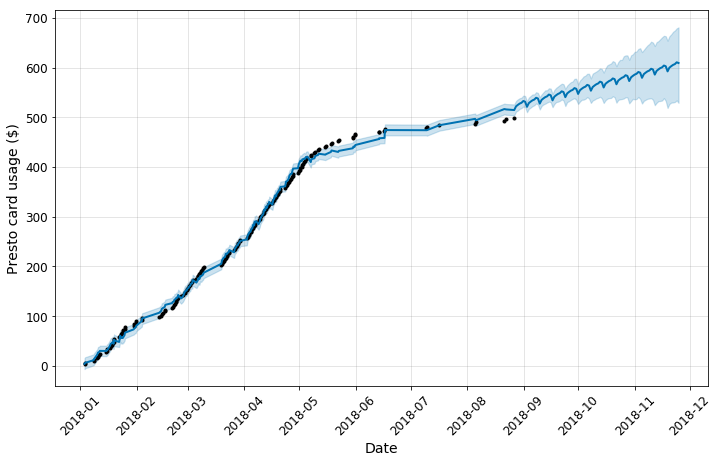

In [13]:
fig1 = m.plot(forecast)
plt.xlabel('Date', fontsize = 14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Presto card usage ($)', fontsize=14)
plt.show()

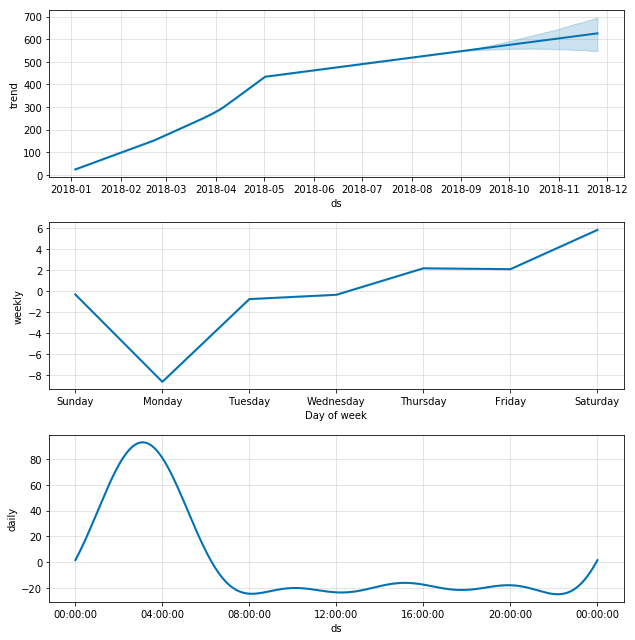

In [14]:
fig2 = m.plot_components(forecast)

### Observations:
- Prophet is **very succesful** in picking up the monthly trend change in May and adjusting the model accordingly.
- It shows a peak in the daily trend at 3am. Could it be that it converts the timestamps to UTC and that pick corresponds to the 8am morning commute?
- The weekly seasonality trend doesn't seem to correlate to what we saw earlier.

#### Plotting the prediction envelope using matplotlib

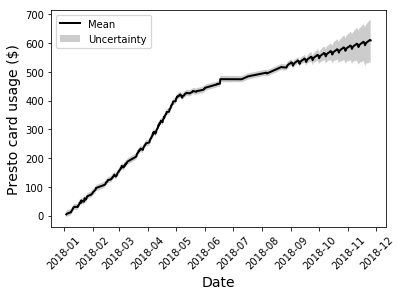

In [15]:
forecast_d = forecast.copy()
forecast_d = forecast_d.set_index('ds')
plt.plot(forecast_d.index, forecast_d.yhat, 'k-', label='Mean')
plt.fill_between(forecast_d.index, forecast_d.yhat_lower, forecast_d.yhat_upper, facecolor='grey', alpha=.4, label='Uncertainty')

plt.ylabel('Presto card usage ($)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(rotation=45)

plt.legend()
plt.show()